# Projekt 2
## Klasyfikacja rodzaju scen filmowych
### Mateusz Kozłowicz, 145293
### Bartłomiej Kowalewski, 145204

## Cel projektu
Celem projektu było przygotowanie modelu uczenia maszynowego dokonującego klasyfikacji rodzaju sceny na podstawie danych informacji.

## 1. Setup, import wykorzystanych bibliotek

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random
from pathlib import Path
from sklearn.model_selection import GridSearchCV

random.seed(23)
np.random.seed(23)

## 2. Wczytanie danych
Jako dane uczące przyjęliśmy foldery 'features' i 'scene_timestamps' zawierające informacje o danej scenie oraz folder 'lables' zawierający rodzaje scen przypisane do id danej sceny.

Dostępne informacje w folderze 'features':

*   s_dur - długość sceny
*   n_shots - liczba ujęć
*   ava_shot_dur - średni czas trwania ujęcia
*   rel_id_loc - względna lokalizacja sceny
*   rel_t_loc - względna lokalizacja czasowa
*   ava_char_score - średni łączny czas wyświetlania postaci w scenie
*   is_prot_appear - czy w scenie pojawia się protagonista

Dostępne informacje w folderze 'scene_timestamps':
*   start - czas rozpoczęcia sceny
*   end - czas zakończenia sceny

In [ ]:
path = r'train'
files = Path(path).glob('*.csv')

In [ ]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    dfs.append(data)

train_df = pd.concat(dfs, ignore_index=True)
train_df.columns.values[0] = "scene_id"

In [ ]:
path = r'labels'
files = Path(path).glob('*.csv')

In [ ]:
dfs = list()
for f in files:
    data = pd.read_csv(f, na_filter= False)
    data['file'] = f.stem
    dfs.append(data)

labels_df = pd.concat(dfs, ignore_index=True)
labels_df.columns.values[0] = "scene_id"
labels_df.columns.values[1] = "label"

In [ ]:
path = r'test'
files = Path(path).glob('*.csv')

In [ ]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    dfs.append(data)

test_df = pd.concat(dfs, ignore_index=True)
test_df.columns.values[0] = "scene_id"

In [ ]:
path = r'scene_timestamps'
files = Path(path).glob('*.csv')

In [ ]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    dfs.append(data)

scene_timestamps_df = pd.concat(dfs, ignore_index=True)
scene_timestamps_df.columns.values[0] = "scene_id"
scene_timestamps_df['file'] = scene_timestamps_df['file'].str.replace('_timestamps', '')

In [ ]:
path = r'test_timestamps'
files = Path(path).glob('*.csv')

In [ ]:
dfs = list()
for f in files:
    data = pd.read_csv(f)
    data['file'] = f.stem
    dfs.append(data)

test_timestamps_df = pd.concat(dfs, ignore_index=True)
test_timestamps_df.columns.values[0] = "scene_id"
test_timestamps_df['file'] = test_timestamps_df['file'].str.replace('_timestamps', '')

In [ ]:
df = pd.merge(train_df, labels_df, on=['file', 'scene_id'])
df = pd.merge(df, scene_timestamps_df, on=['file', 'scene_id'])

In [ ]:
test_df = pd.merge(test_df, test_timestamps_df, on=['file', 'scene_id'])

## 3. Przygotowanie modelu
Wybraliśmy Random Forest jako nasz model do klasyfikacji, ponieważ potrafi on ocenić istotność poszczególnych cech podczas procesu uczenia. W celu dobrania najlepszych parametrów klasyfikatora przeprowadziliśmy GridSearch.

In [ ]:
X = df.drop(['label', 'file'], axis = 1)
# X = df.drop(['label', 'file', 'scene_id'], axis = 1)
# X = df.drop(['label', 'file', 'start', 'end'], axis = 1)
# X = df.drop(['label', 'file', 'scene_id', 'start', 'end'], axis = 1)
y = df['label']
X_test = test_df.drop(['file'], axis = 1)
# X_test = test_df.drop(['file', 'scene_id'], axis = 1)
# X_test = test_df.drop(['file', 'start', 'end'], axis = 1)
# X_test = test_df.drop(['file', 'scene_id', 'start', 'end'], axis = 1)

In [ ]:
forest = RandomForestClassifier(criterion="gini")
parameters = {'max_depth': [5, 6, 7, 8, 9, 10], 'n_estimators': [20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}
rf = GridSearchCV(forest, parameters, cv=5)
rf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 25, 26, 27, 28, 29, 30, 31, 32,
                                          33, 34, 35, 36, 37, 38, 39, 40, 41,
                                          42, 43, 44, 45]})

Wykres istotności cech:

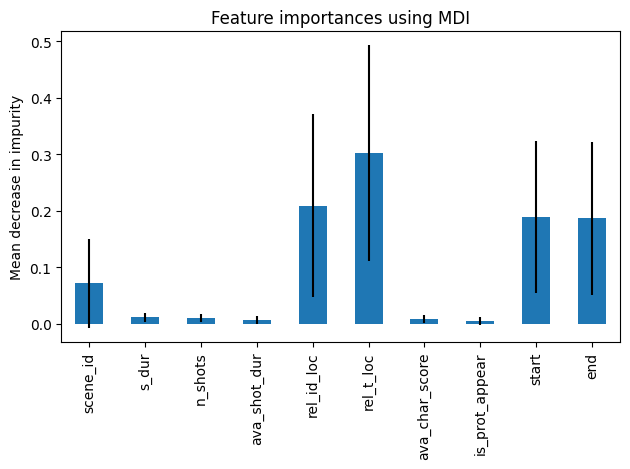

In [ ]:
importances = rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.best_estimator_.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4. Wyniki

In [ ]:
print('Best Estimator: ', rf.best_estimator_)
print('Best Score: ',rf.best_score_)
print('Best Parameters: ', rf.best_params_)

Best Estimator:  RandomForestClassifier(max_depth=5, n_estimators=40)
Best Score:  0.5067911886476407
Best Parameters:  {'max_depth': 5, 'n_estimators': 40}


In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
test_df['label'] = y_pred

## 5. Zapis do pliku CSV

In [ ]:
submission_csv = pd.DataFrame()
submission_csv['Id'] = test_df['file'].str.slice(0,9) + "_" + test_df['scene_id'].astype(str)
submission_csv['Label'] = test_df['label']
submission_csv['movie_id'] = submission_csv['Id'].str.slice(2,9).astype(int)
submission_csv['scene_id'] = submission_csv['Id'].str.slice(10,).astype(int)
submission_csv.sort_values(by=['movie_id', 'scene_id'], inplace = True)
submission_csv.drop(['movie_id', 'scene_id'], axis=1).to_csv('rfc_submission_timestamps.csv', index=False)
# submission_csv.sort_values(by=['Id'], key=lambda s: s.str[2:8].astype(int), inplace = True)